# 1. Business Understanding

Developing an automated and standardized classification model that can be used on any source to enrich the originally available data with industry sector information.  
Ultimately the task can be framed as an error/anomaly detection task. At the core, it is still a classification problem and the output should be not the ultimate result, but discussable qualitative results in the form of false positives and false negatives identified in the data.  

For each of the 32 top-level classes it is expected to see:
1. 10 false positives from the data
2. 10 false negatives from the data




In [137]:
# importing libraries
# the basic
import pandas as pd
import numpy as np
import re

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
plt.style.use('seaborn')

# internet and API
import requests

# NLP libraries
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
sp= spacy.load('en')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')

# sklearn!
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC



SEED= 12345

# 2. Data Understanding + Feature Extraction

I will analyze the csv provided

In [3]:
!wget -qO- -O tmp.zip https://gitlab.ontotext.com/trainings/global_datathon/raw/master/data/dt18-ontotext-simple.csv.zip && unzip tmp.zip && rm tmp.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# reading the provided csv in a df
df= pd.read_csv('dt18-ontotext-simple.csv')

Checking the types and nulls of the df

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277419 entries, 0 to 277418
Data columns (total 7 columns):
org             277419 non-null object
names           276544 non-null object
types           277419 non-null object
descriptions    264897 non-null object
locations       144509 non-null object
categories      276224 non-null object
industries      259477 non-null object
dtypes: object(7)
memory usage: 14.8+ MB


## 2.1 Explore the target variable

In [4]:
print('The target columns industries contains {} nulls, the {:.1f}% of the total'.format(
    df['industries'].isnull().sum(), df['industries'].isnull().sum() / df.shape[0] * 100))

The target columns industries contains 17942 nulls, the 6.5% of the total


In [5]:
df['industries'][:10]

0                     Education
1                     Education
2                        Retail
3                     Education
4                     Education
5       Transport;Manufacturing
6                     Education
7    Transport;Travel_and_sport
8                        Mining
9                 Manufacturing
Name: industries, dtype: object

I will remove the null labeld rows, not imputing the target now.

In [6]:
# saving the null target in a new df
df_null_target= df[df['industries'].isnull()]
df.dropna(subset=['industries'], inplace= True)

The target variable 'industries' contain the label for the company. It's clear that a company can have more than one label. How many unique labels do we have?

In [7]:
# creating a dummy df with single label for industries
industries_dummy= df['industries'].str.split(';').str.join('|').str.get_dummies()

In [8]:
print('In industries there are', len(industries_dummy.columns), 'classes')

In industries there are 32 classes


Text(0.5, 1.0, 'Comapany Classes')

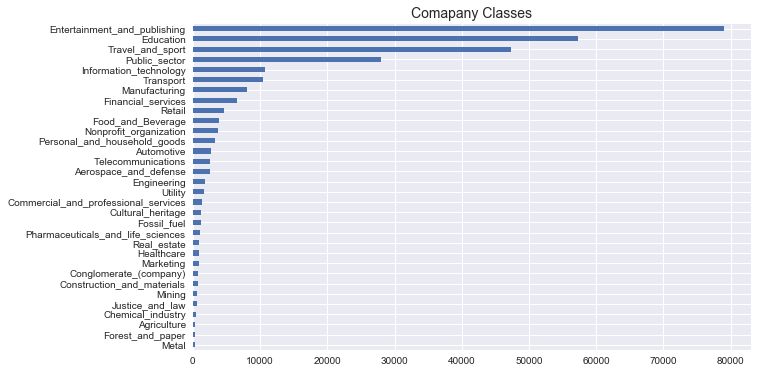

In [9]:
industries_class= industries_dummy.sum().sort_values()
industries_class.plot(kind='barh', figsize=(10,6))
plt.title('Comapany Classes', fontsize= 14)

Let's see if the classes appear evenly

It is evident that the classes are not balanced

In [10]:
print('The top 5 classes: {}, account for {:.0f}% of the data'.format(
    '; '.join(industries_class[-5:].index), industries_class[-5:].sum() / industries_class.sum() *100))

The top 5 classes: Information_technology; Public_sector; Travel_and_sport; Education; Entertainment_and_publishing, account for 78% of the data


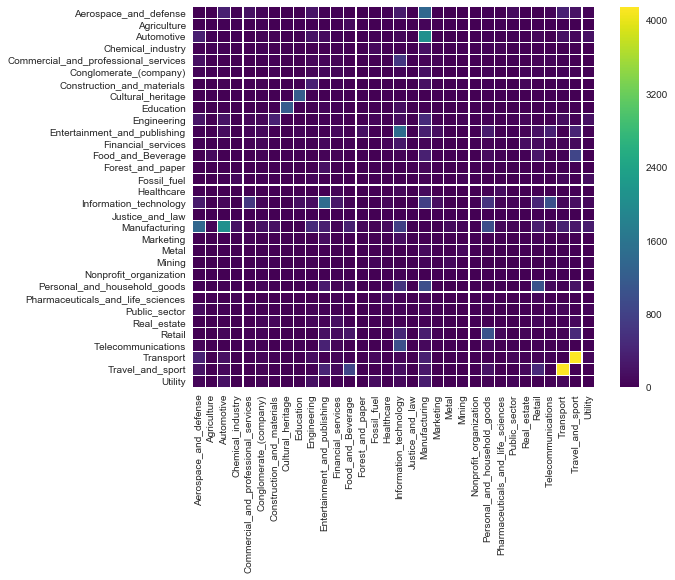

In [11]:
# creating dot matrix for industries
industries_matrix= industries_dummy.T.dot(industries_dummy)
# diagonal = 0, no stand out same combination
np.fill_diagonal(industries_matrix.values, 0)
plt.figure(figsize= (9, 7))
sns.heatmap(industries_matrix, cmap= 'viridis', robust= False, linewidths= 0.1)

How many companies have multiple label, how are they linked?

In [12]:
print('The {:.2f}% of the companies has more than one class. In average there are {:.3f} classes per company'.format(
df[df['industries'].str.split(';').apply(lambda x: len(x))>1].shape[0] / df.shape[0] *100,
    df['industries'].str.split(';').apply(lambda x: len(x)).mean() ))
max_n_class= df['industries'].str.split(';').apply(lambda x: len(x)).max()
print('The max number of classes per company is', max_n_class)

The 8.54% of the companies has more than one class. In average there are 1.105 classes per company
The max number of classes per company is 12


What the company with max classes actually doing?

In [13]:
df[df['industries'].str.split(';').apply(lambda x: len(x)) == max_n_class]

org  \
138537  http://dbpedia.org/resource/Al_Ghurair_Investment   

                        names         types  \
138537  Al Ghurair Investment  Company;Bank   

                                             descriptions  \
138537  Al Ghurair (Arabic:الغرير), also known as Al G...   

                                          locations  \
138537  United_Arab_Emirates;Dubai;Deira,_Dubai;UAE   

                                               categories  \
138537  Companies_of_the_United_Arab_Emirates;Companie...   

                                               industries  
138537  Retail;Transport;Financial_services;Telecommun...

Transport and Travel( and_sport) appears together quite often, and roughly 40% of the Transport labeled companies are also labeled as Travel_and_sport, Manufacturing is linked to Automotive and Aerospace_and_defense.  
How class are linked between them, not counting the appearance in the overall dataset?

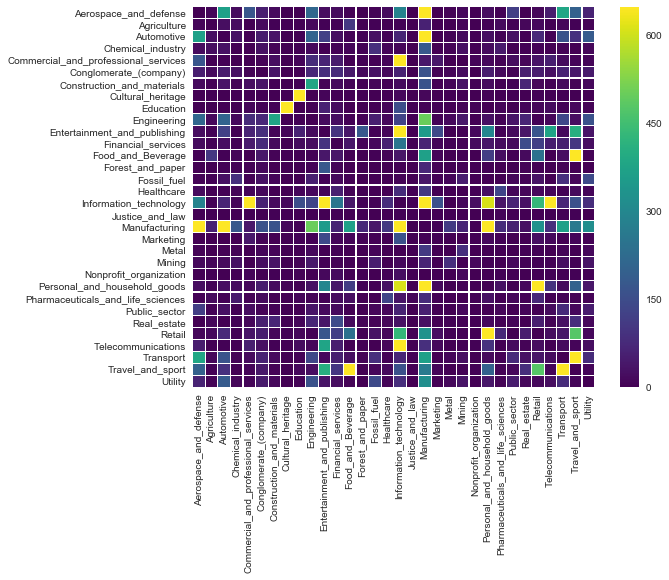

In [14]:
plt.figure(figsize= (9, 7))
sns.heatmap(industries_matrix, cmap= 'viridis', robust= True, linewidths= 0.1)

Now we have a better idea of the target variable, let's explore the other features

## 2.2. Explore the features

### Descriptions

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259477 entries, 0 to 277412
Data columns (total 7 columns):
org             259477 non-null object
names           258794 non-null object
types           259477 non-null object
descriptions    248249 non-null object
locations       131946 non-null object
categories      258542 non-null object
industries      259477 non-null object
dtypes: object(7)
memory usage: 15.8+ MB


Only 'org' and 'types' don't have nulls, the missing 'names' could be retrivable from 'org'.
Let's check if this is needed: the missing descriptions could be retrived with web scraping, but the name it's necessary for this step.  
But first, I will check the target variable

In [16]:
df[['org', 'names', 'descriptions']][df['names'].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 185711 to 277412
Data columns (total 3 columns):
org             683 non-null object
names           0 non-null object
descriptions    0 non-null object
dtypes: object(3)
memory usage: 21.3+ KB


The 'org's without a name also don't have a description, filling the missing names it's going to be useful, Let's check 'org' and see how to retrive the name

In [17]:
for i in range(4):
    print(df[df['names'].isnull()]['org'].iloc[i])

http://dbpedia.org/resource/Dave_Brubeck__The_Dave_Brubeck_Quartet__1
http://dbpedia.org/resource/Hungary__Current_Structure_of_the_National_Assembly_of_Hung__1
http://dbpedia.org/resource/Mexico_City__Ciudad_Universitaria__1
http://dbpedia.org/resource/Moxie__Beverage_Company__1


The companies without a name respect a pattern: text1__text2__1, 
In general, using the 'org' field is possible to get a description from https://www.wikipedia.org/, searching for the page related to that entry.  
Let's check if it possible to complete the 'description' field.

In [18]:
def get_wiki_description(x):
    '''If description is not present, get wiki description and categories from dbpedia org'''
    # if description, return unmodified Serie
    if type(x['descriptions']) is str and type(x['categories']):
        return x
    
    else: # if no description search in wikipedia
        S = requests.Session()
        URL = "https://en.wikipedia.org/w/api.php"
        # extract only words betweeen resource and __ in org
        SEARCHTERM= x['org'].split('resource/')[1].split('__')[0]
        PARAMS = {
            'action':"opensearch",
            'search':SEARCHTERM,
            'limit': 1,
            'namespace':0,
            'format':"json" }
        # opensearch on wikipedia
        R = S.get(url=URL, params=PARAMS)
        # if no result result(there is webpage link)
        if (len(R.json()[3]) > 0) and type(x['descriptions']) is not str:
            # description in search result
            x['descriptions']= R.json()[2][0]
            
        if (len(R.json()[3]) > 0) and type(x['categories']) is not str:  
            try:
                PARAMS = {
                    'action':"query",
                    'titles': R.json()[0],
                    'format':"json", 
                    'prop': "categories"}
                #search for categories
                R= S.get(url=URL, params=PARAMS)
                #create a string, _ separated words, ; separated entried
                cat_list= []
                for cat in list(R.json()['query']['pages'].values())[0]['categories']:
                    search_list= ['Wiki', 'Articles', 'Webarchive', 'articles', 'ISO', 'dmy', 'errors', 'Pages']
                    # format as the rest of the categories
                    if not re.compile('|'.join(search_list)).search(cat['title']):
                        cat_list.append(cat['title'].split(':')[1].replace(' ','_'))
                x['categories']= ';'.join(cat_list)
            except:   
                print(R.json()['query']['pages'].values())
            
        return x   

In [19]:
# UNCOMMENT ONLY IF REFERSH df (long time)
#df= df.apply(get_wiki_description, axis=1)
#df.to_pickle('ontotext_description_df.pkl')

In [20]:
df= pd.read_pickle('ontotext_description_df.pkl')

In [21]:
def get_name(x):
    # simple function takes name from org
    if type(x['names']) is not str:
        x['names']= x['org'].split('resource/')[1].split('__')[0].replace('_', ' ')
    return x['names']

df['names']= df.apply(get_name, axis= 1)

Let's check if all the org has a description, using the description length

In [22]:
# calculating n of char in description
df['descriptions_len']= df['descriptions'].str.split(' ').str.len()
print(df[df['descriptions_len']== 1].shape[0], 'org have an empty description')

965 org have an empty description


I will removing the org that remains without descriptions

In [23]:
df= df[df['descriptions_len']> 1]

How is description distributed?

In [24]:
df['descriptions_len'].describe()

count    258059.000000
mean         86.349699
std          85.278994
min           2.000000
25%          34.000000
50%          60.000000
75%         108.000000
max        3831.000000
Name: descriptions_len, dtype: float64

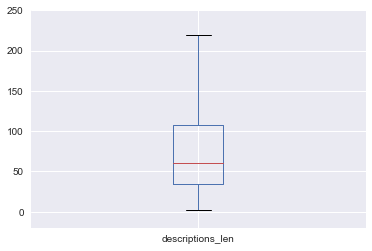

In [25]:
df['descriptions_len'].plot(kind= 'box', ylim= (-20,250))

#### Description vs Industry labels

Text(0.5, 0, 'n of class')

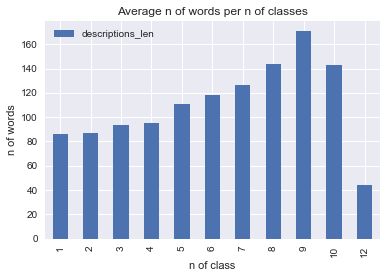

In [26]:
df.groupby(industries_dummy.sum(axis=1)).mean().plot(kind= 'bar')
plt.title('Average n of words per n of classes')
plt.ylabel('n of words')
plt.xlabel('n of class')

Until 9 classes, there is a positive relationship between the number of classes and the average number of words in 'descriptions'

### Type

every org has one(or more, separated by ; ) types, I will start to analyzing this field

In [27]:
print('Number of unique type:', len(df['types'].str.split(';', expand= True).apply(pd.Series).stack().value_counts()))
print('\n10 most common types:')
df['types'].str.split(';', expand= True).apply(pd.Series).stack().value_counts()[:10]      

Number of unique type: 69

10 most common types:


Company                   62697
EducationalInstitution    56724
Group                     35371
Band                      35295
SportsTeam                34568
School                    34029
Broadcaster               30411
SoccerClub                22360
College                   20978
University                20714
dtype: int64

While there are 69 different types, types as School, College coulb be group with EducationalInstituion and Team, Club under a Sport group

In [28]:
# dict, key grouping if types contain values
types_dict= {'Sports': 'Team|Club|Sports|League',
           'Educational': 'University|Educational|College|School',
           'Broadcaster': 'Broadcaster|Radio|Television|Publisher'}

# iterate over dict
for key, value in types_dict.items():
    df['types']= np.where(df['types'].str.contains(value), key, df['types'])

In [29]:
types_dummy= df['types'].str.get_dummies()
industries_dummy= df['industries'].str.split(';').str.join('|').str.get_dummies()

Text(0.5, 1.0, 'Types Grouped')

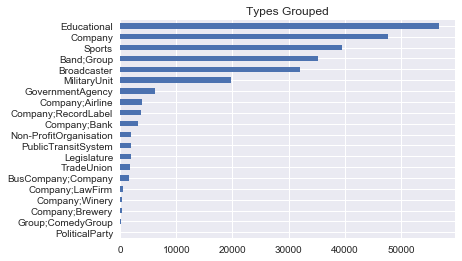

In [30]:
types_dummy.sum(axis=0).sort_values().plot(kind='barh')
plt.title('Types Grouped')

How 'types' relate to 'industry'?

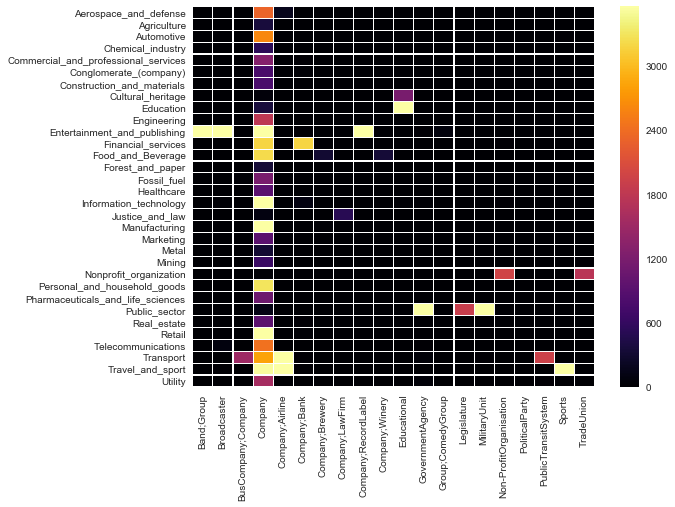

In [31]:
# creating dot matrix for industries
types_industries_matrix= industries_dummy.T.dot(types_dummy)
# diagonal = 0, no stand out same combination
#np.fill_diagonal(industries_matrix.values, 0)
plt.figure(figsize= (9, 7))
sns.heatmap(types_industries_matrix, cmap= 'inferno', robust= True, linewidths= 0.1)

While the type Company can fall in many industries, type as educational fall only in one industry calss (in this case Education).  
Let's group even more: e.g. the 'types' GovermentAgency, Legisture and MilitaryUnit all fall under the  Public_sector 'industry'. PoliticalParty(s) are a problematic type: they have few industries associated with them and the labels are incorrect: I will group them in the non-profit type

In [32]:
# dict, key grouping if types contain values
types_dict= {'PublicSector': 'Government|Military|Legislature',
             'NonProfit': 'TradeUnion|Political|Non-Profit',
             'Entertainment': 'Band|Comedy|RecordLabel',
             'Bank': 'Bank',
             'Law': 'Law',
             'Alcohol': 'Winery|Brewery',
             'Bus': 'BusCompany|Transit',
             'Airplane': 'Airline' # Airlines can be Transport or Travel and Sport
            }

# iterate over dict
for key, value in types_dict.items():
    df['types']= np.where(df['types'].str.contains(value), key, df['types'])

We are down to 12 'types', let's visualize them:

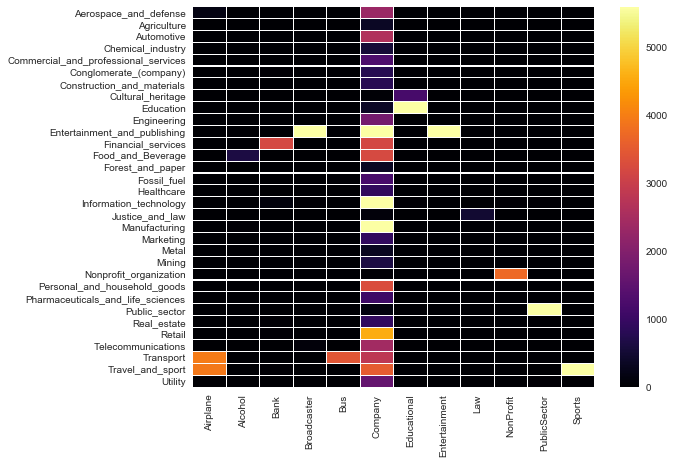

In [33]:
# recreating dummy types
types_dummy= df['types'].str.get_dummies()
# creating dot matrix for industries
types_industries_matrix= industries_dummy.T.dot(types_dummy)
# diagonal = 0, no stand out same combination
#np.fill_diagonal(industries_matrix.values, 0)
plt.figure(figsize= (9, 7))
sns.heatmap(types_industries_matrix, cmap= 'inferno', robust= True, linewidths= 0.1)

But for Company, 'types' have a maxium of 2 industries labels associated

# 3. Data Preparation

## 3.1. Text Visualization

Let's visualize the text using WordCloud.  
As text, I will use 'categories' and not 'descriptions', 'categories' is less noisy than 'descriptions' and appears as a good recap of the last.

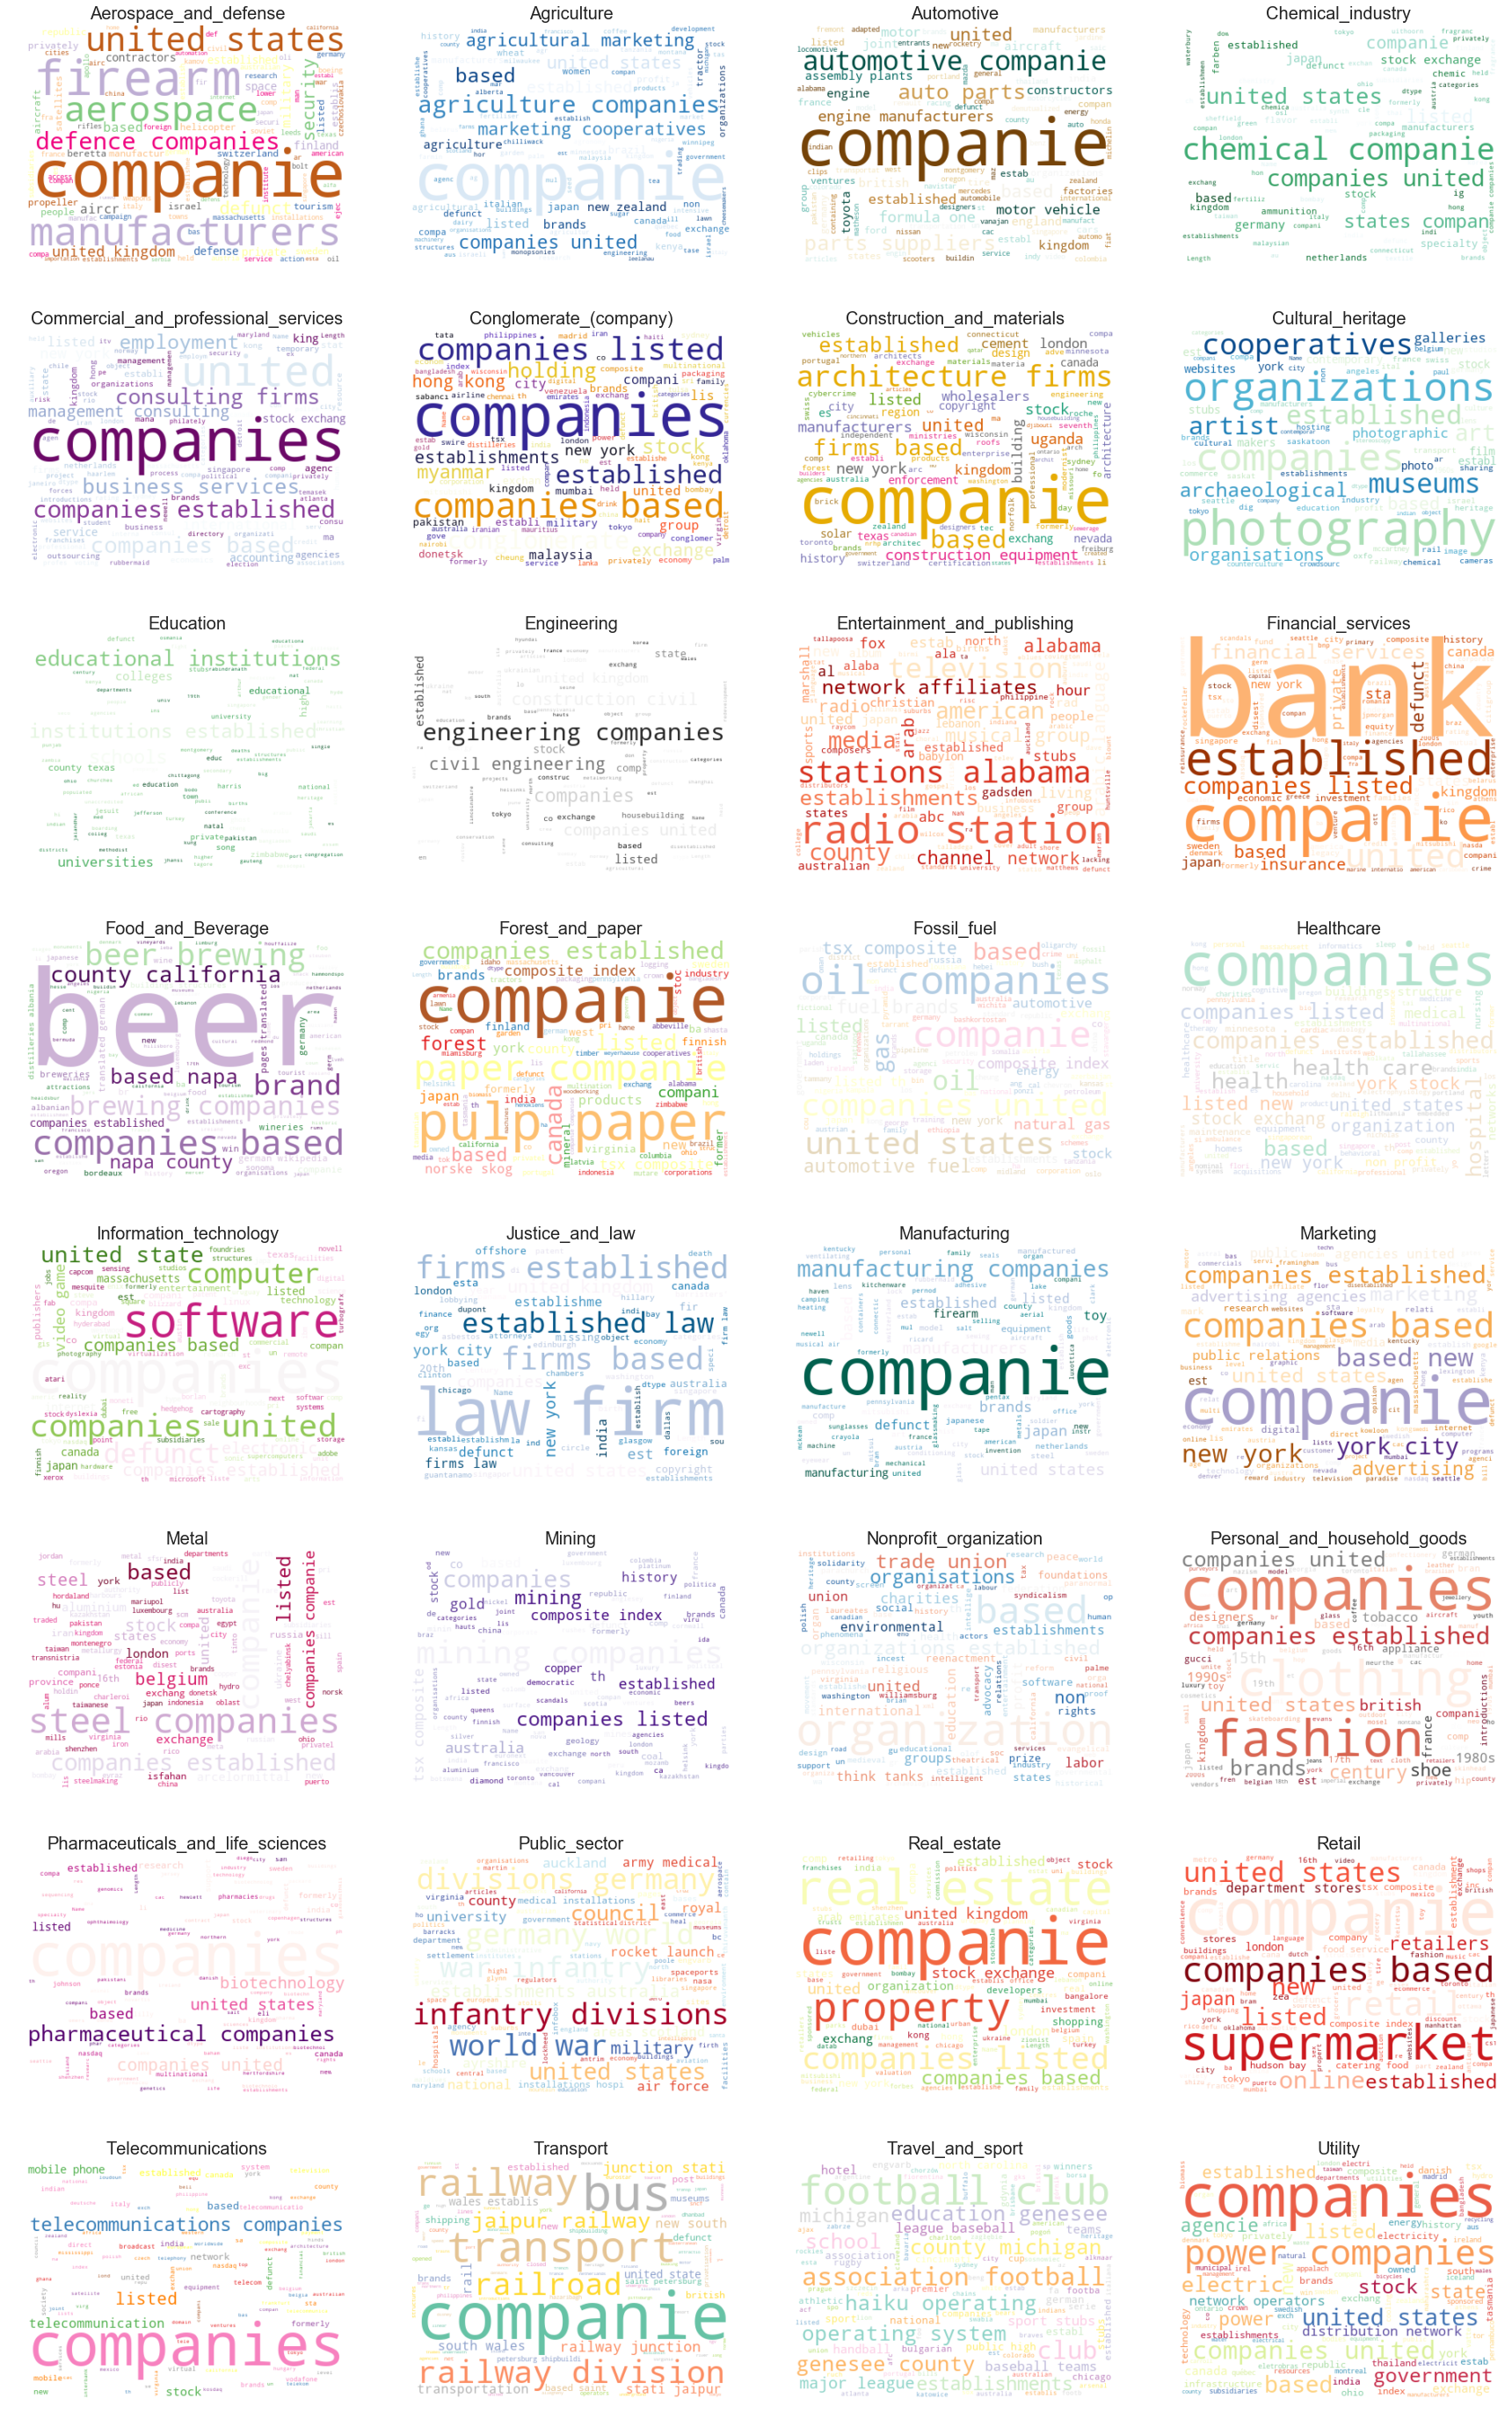

In [34]:
ind_labels= industries_dummy.columns
cm = plt.colormaps()
fig = plt.figure(figsize= (30, 50))
for i in range(len(ind_labels)):
    mask = df['industries'] == ind_labels[i]
    text= df[mask]['categories'].str.replace('_', ' ').str.replace(';', ' ').str.lower()
    ax = fig.add_subplot(8 ,4,i+1)
    wordcloud = WordCloud(max_font_size=200, height= 300, max_words=100, colormap= cm[i*2],
                           background_color="white").generate(str(text))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(ind_labels[i], size= 20)
    ax.axis('off')

Following 'types' many categories contain the word company (and derivate)  
As mantion above 'categories' contains many important words that can allow to correctly classify an organization, I will use the words (stemmed) that are contained in both features, adding also the 'types'

In [35]:
# target
y= df['industries']

# features
X= df.drop(columns= ['org', 'locations', 'names', 'industries', 'descriptions_len'])

## 3.2 Text Processing

I will take only the words that are presents in both 'descriptions' and 'categories'.  
This will help reduce the number of features, without loosing the important ones. As a cons we will lose the sentences syntax

In [36]:
def text_cleaner(x):
    # token of descrtiptions, only words, non capital (personal noun)
    desc_list= [stemmer.stem(token) for token in re.sub(r'[^A-Za-z\s]','', x['descriptions']).split() if len(token)> 1 and token[0].islower()]
    # if categories is not empty create a list of token (no digit no stop words)
    if type(x['categories']) is str:
        cat_list= x['categories'].replace(';', '_').split('_')
        cat_list= [stemmer.stem(token) for token in cat_list if token if not token.isdigit() and token not in STOP_WORDS]
    else: # else list is empty
        cat_list= []
    # create a set of words intersections desc and cat
    combined_set = {word for word in cat_list if word in desc_list}
    
    # if in the intersection less than 2 words use noun in descriptions (only latin letters)
    if len(combined_set)<2:
        sentence= sp(x['descriptions'], disable=['entity', 'vectors', 'textcat', 'ner', 'parser'])
        combined_set= {stemmer.stem(token.text) for token in sentence if token.pos_ == 'NOUN' and len(token) == len(str(token).encode())}
    
    # if types not company add it to the words
    if x['types'] != 'Company':
            combined_set.add(x['types'])
    
    #return the cleaned string
    return ' '.join(combined_set)

X['text_clean']= X.apply(text_cleaner, axis=1)

Initially I will take in consideration, to optimize the vectorizer, only the single label data

In [37]:
y_single= y[y.isin(ind_labels)]
X_single= X[y.isin(ind_labels)]['text_clean']

I will use a randomized search to get the best vectorizer

In [87]:
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                     ('lr', LogisticRegression(class_weight= 'balanced', multi_class='auto'))])
params = {'tfidf__use_idf':(False,True),
         'tfidf__min_df': (2, 3, 5 ),
         'tfidf__max_df':(0.7, 0.8, 0.9),
         'tfidf__ngram_range': ((1,1), (1,2))}

randomsearch = RandomizedSearchCV(pipeline,params,cv=3, n_iter= 15)
randomsearch.fit(X_single,y_single)
print(randomsearch.best_params_)

C:\Users\MarioPorta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'tfidf__use_idf': True, 'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 2, 'tfidf__max_df': 0.7}


In [88]:
randomsearch.best_score_

0.967840073217857

Text(0.5, 1.0, 'Top 25 $\\chi^2$ features')

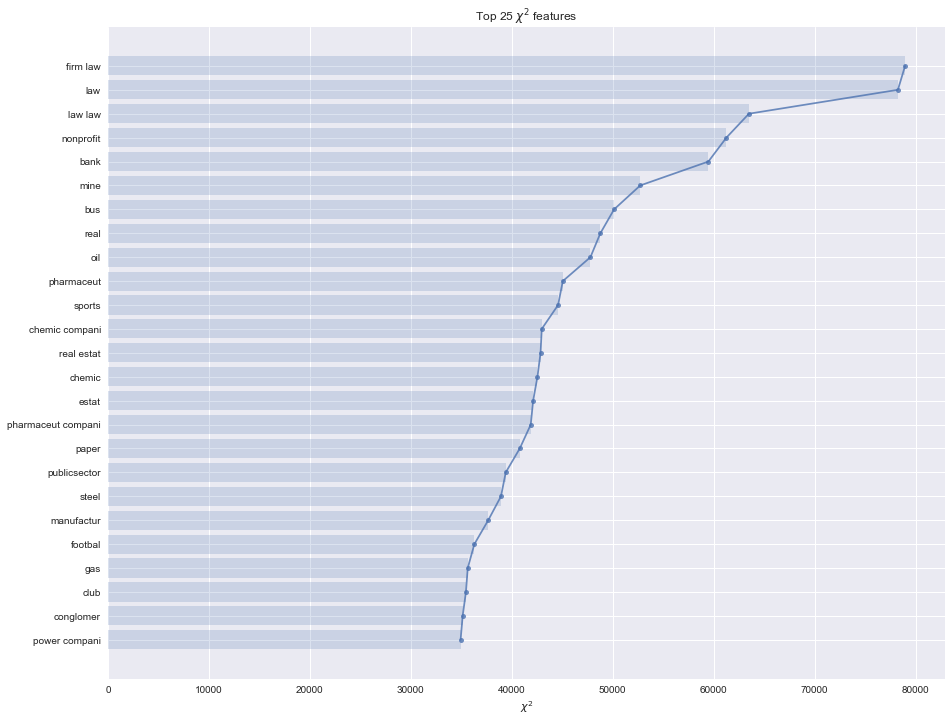

In [72]:
tvec= TfidfVectorizer(min_df= 2, max_df= 0.7, ngram_range= (1, 2))
X_single_vec = tvec.fit_transform(X_single)
chi2score = chi2(X_single_vec, y_single)[0]

plt.figure(figsize=(15,12))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-25:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.title('Top 25 $\chi^2$ features')

Checking the most recurrent words in the cleaned text

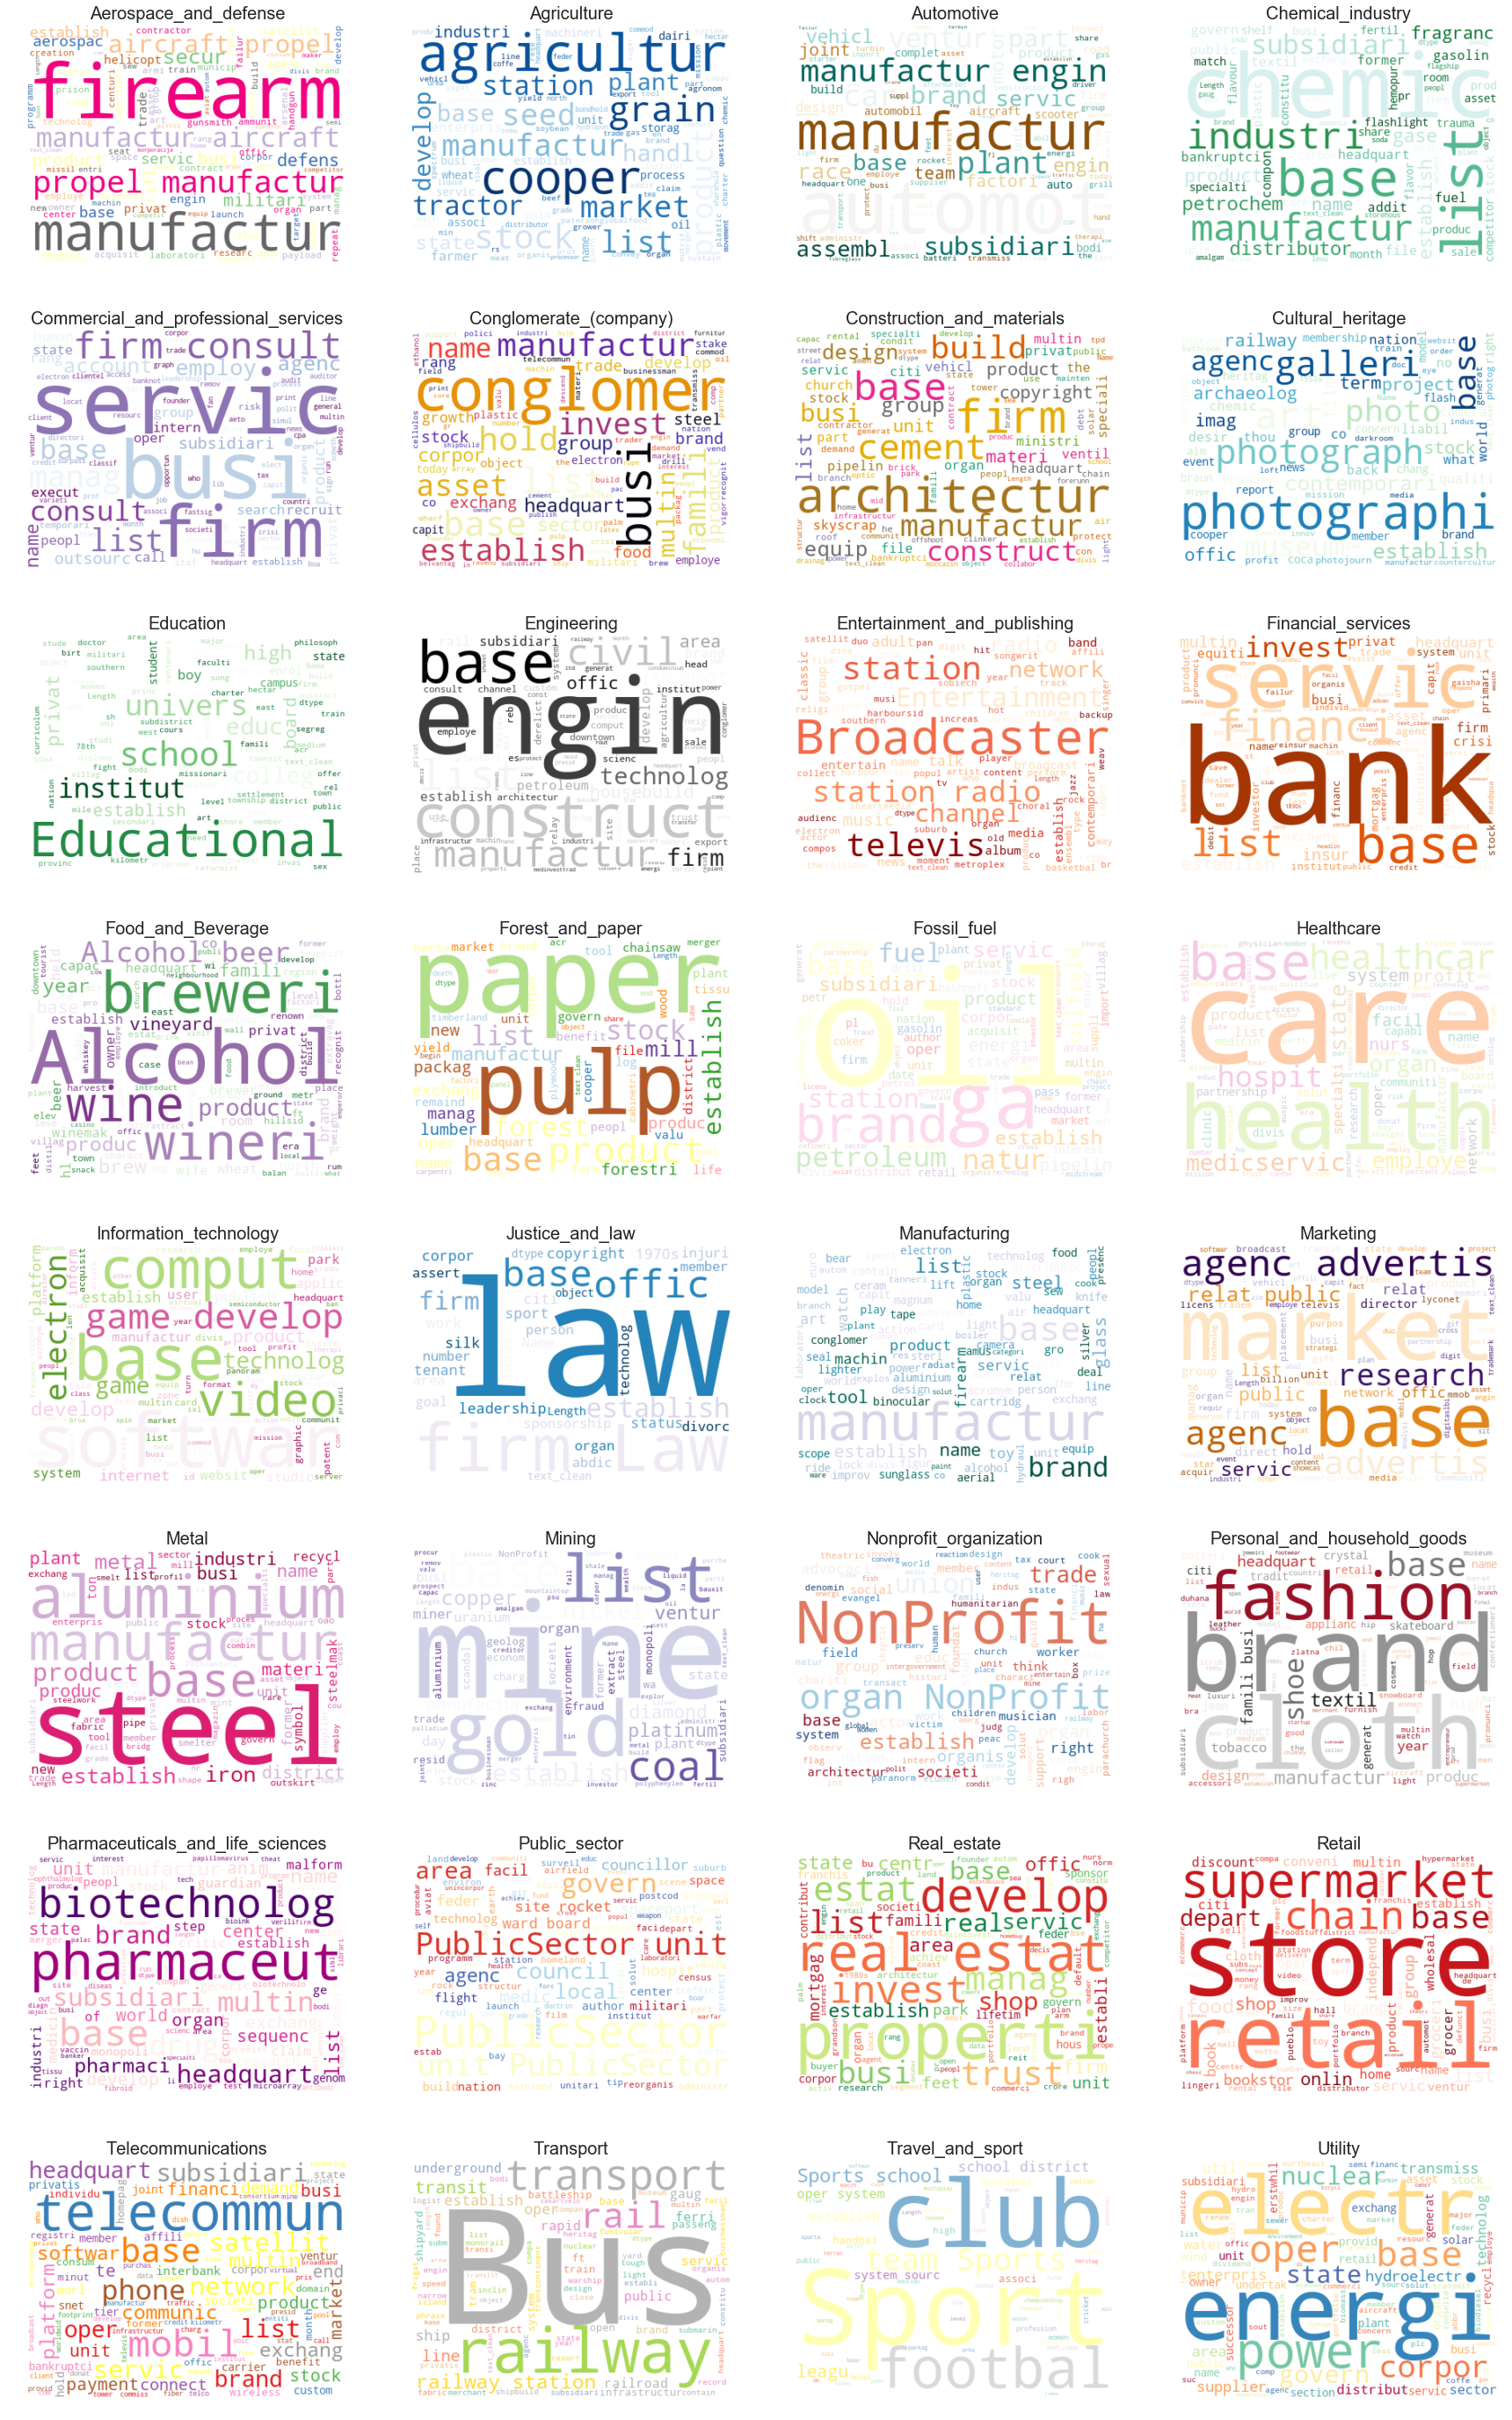

In [45]:
ind_labels= industries_dummy.columns
cm = plt.colormaps()
fig = plt.figure(figsize= (30, 50))
for i in range(len(ind_labels)):
    mask = y_single == ind_labels[i]
    text= X_single[mask]
    ax = fig.add_subplot(8 ,4,i+1)
    wordcloud = WordCloud(max_font_size=200, height= 300, max_words=100, colormap= cm[i*2], stopwords= ['compani'],
                           background_color="white").generate(str(text))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(ind_labels[i], size= 20)
    ax.axis('off')

## 3.3Train-Test Split

In [166]:
train, test = train_test_split(X.join(industries_dummy),
                               random_state=SEED, test_size=0.60, shuffle=True, stratify= X['types'])
X_train_vec = tvec.fit_transform(train['text_clean'])
X_test_vec = tvec.transform(test['text_clean'])

In [167]:
y_train= train.iloc[:,4:]
y_test= test.iloc[:,4:]

# 4. Result and Evaluation

To tackle this problem i will use the OneVsRest approach: decomposing the problem into multiple independent binary classification problems (one per category).

In [177]:
# Using pipeline for applying logistic regression and one vs rest classifier
LR= OneVsRestClassifier(LogisticRegression(solver='lbfgs', class_weight ='balanced'))
lr_accuracy= {}
lr_pred= {}
for category in ind_labels:
    # train the model
    LR.fit(X_train_vec, y_train[category])
    # compute the testing accuracy
    prediction = LR.predict(X_test_vec)
    lr_pred[category]= prediction
    lr_accuracy[category]= accuracy_score(y_test[category], prediction)

C:\Users\MarioPorta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\MarioPorta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\MarioPorta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\MarioPorta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\MarioPorta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

In [288]:
SVC = OneVsRestClassifier(LinearSVC())
svc_accuracy= {}
svc_pred= {}
for category in ind_labels:
    # train the model
    SVC.fit(X_train_vec, y_train[category])
    # compute the testing accuracy
    prediction = SVC.predict(X_test_vec)
    svc_pred[category]= prediction
    svc_accuracy[category]= accuracy_score(y_test[category], prediction)
    confusion_matrix(y_test[category], prediction)

([<matplotlib.axis.XTick at 0x223bb14cc88>,
 <a list of 32 Text xticklabel objects>)

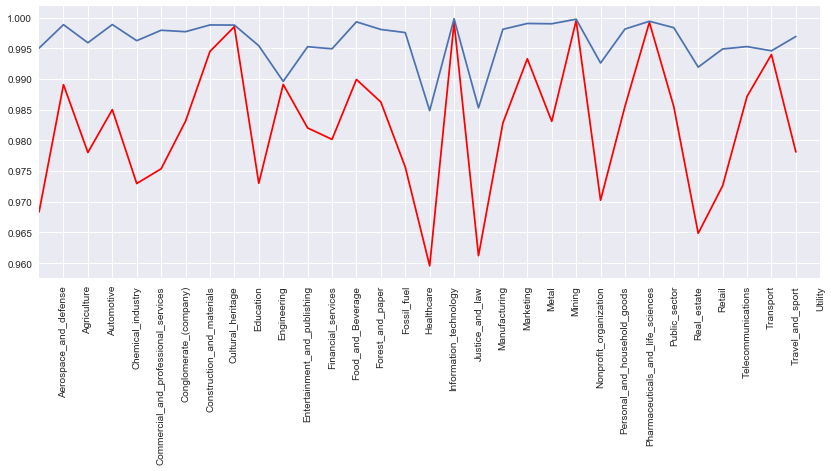

In [263]:
plt.figure(figsize= (14,5))
pd.Series(lr_accuracy).plot(color='red')
pd.Series(svc_accuracy).plot()
plt.xticks((range(1,len(ind_labels)+1)), ind_labels, rotation='vertical')

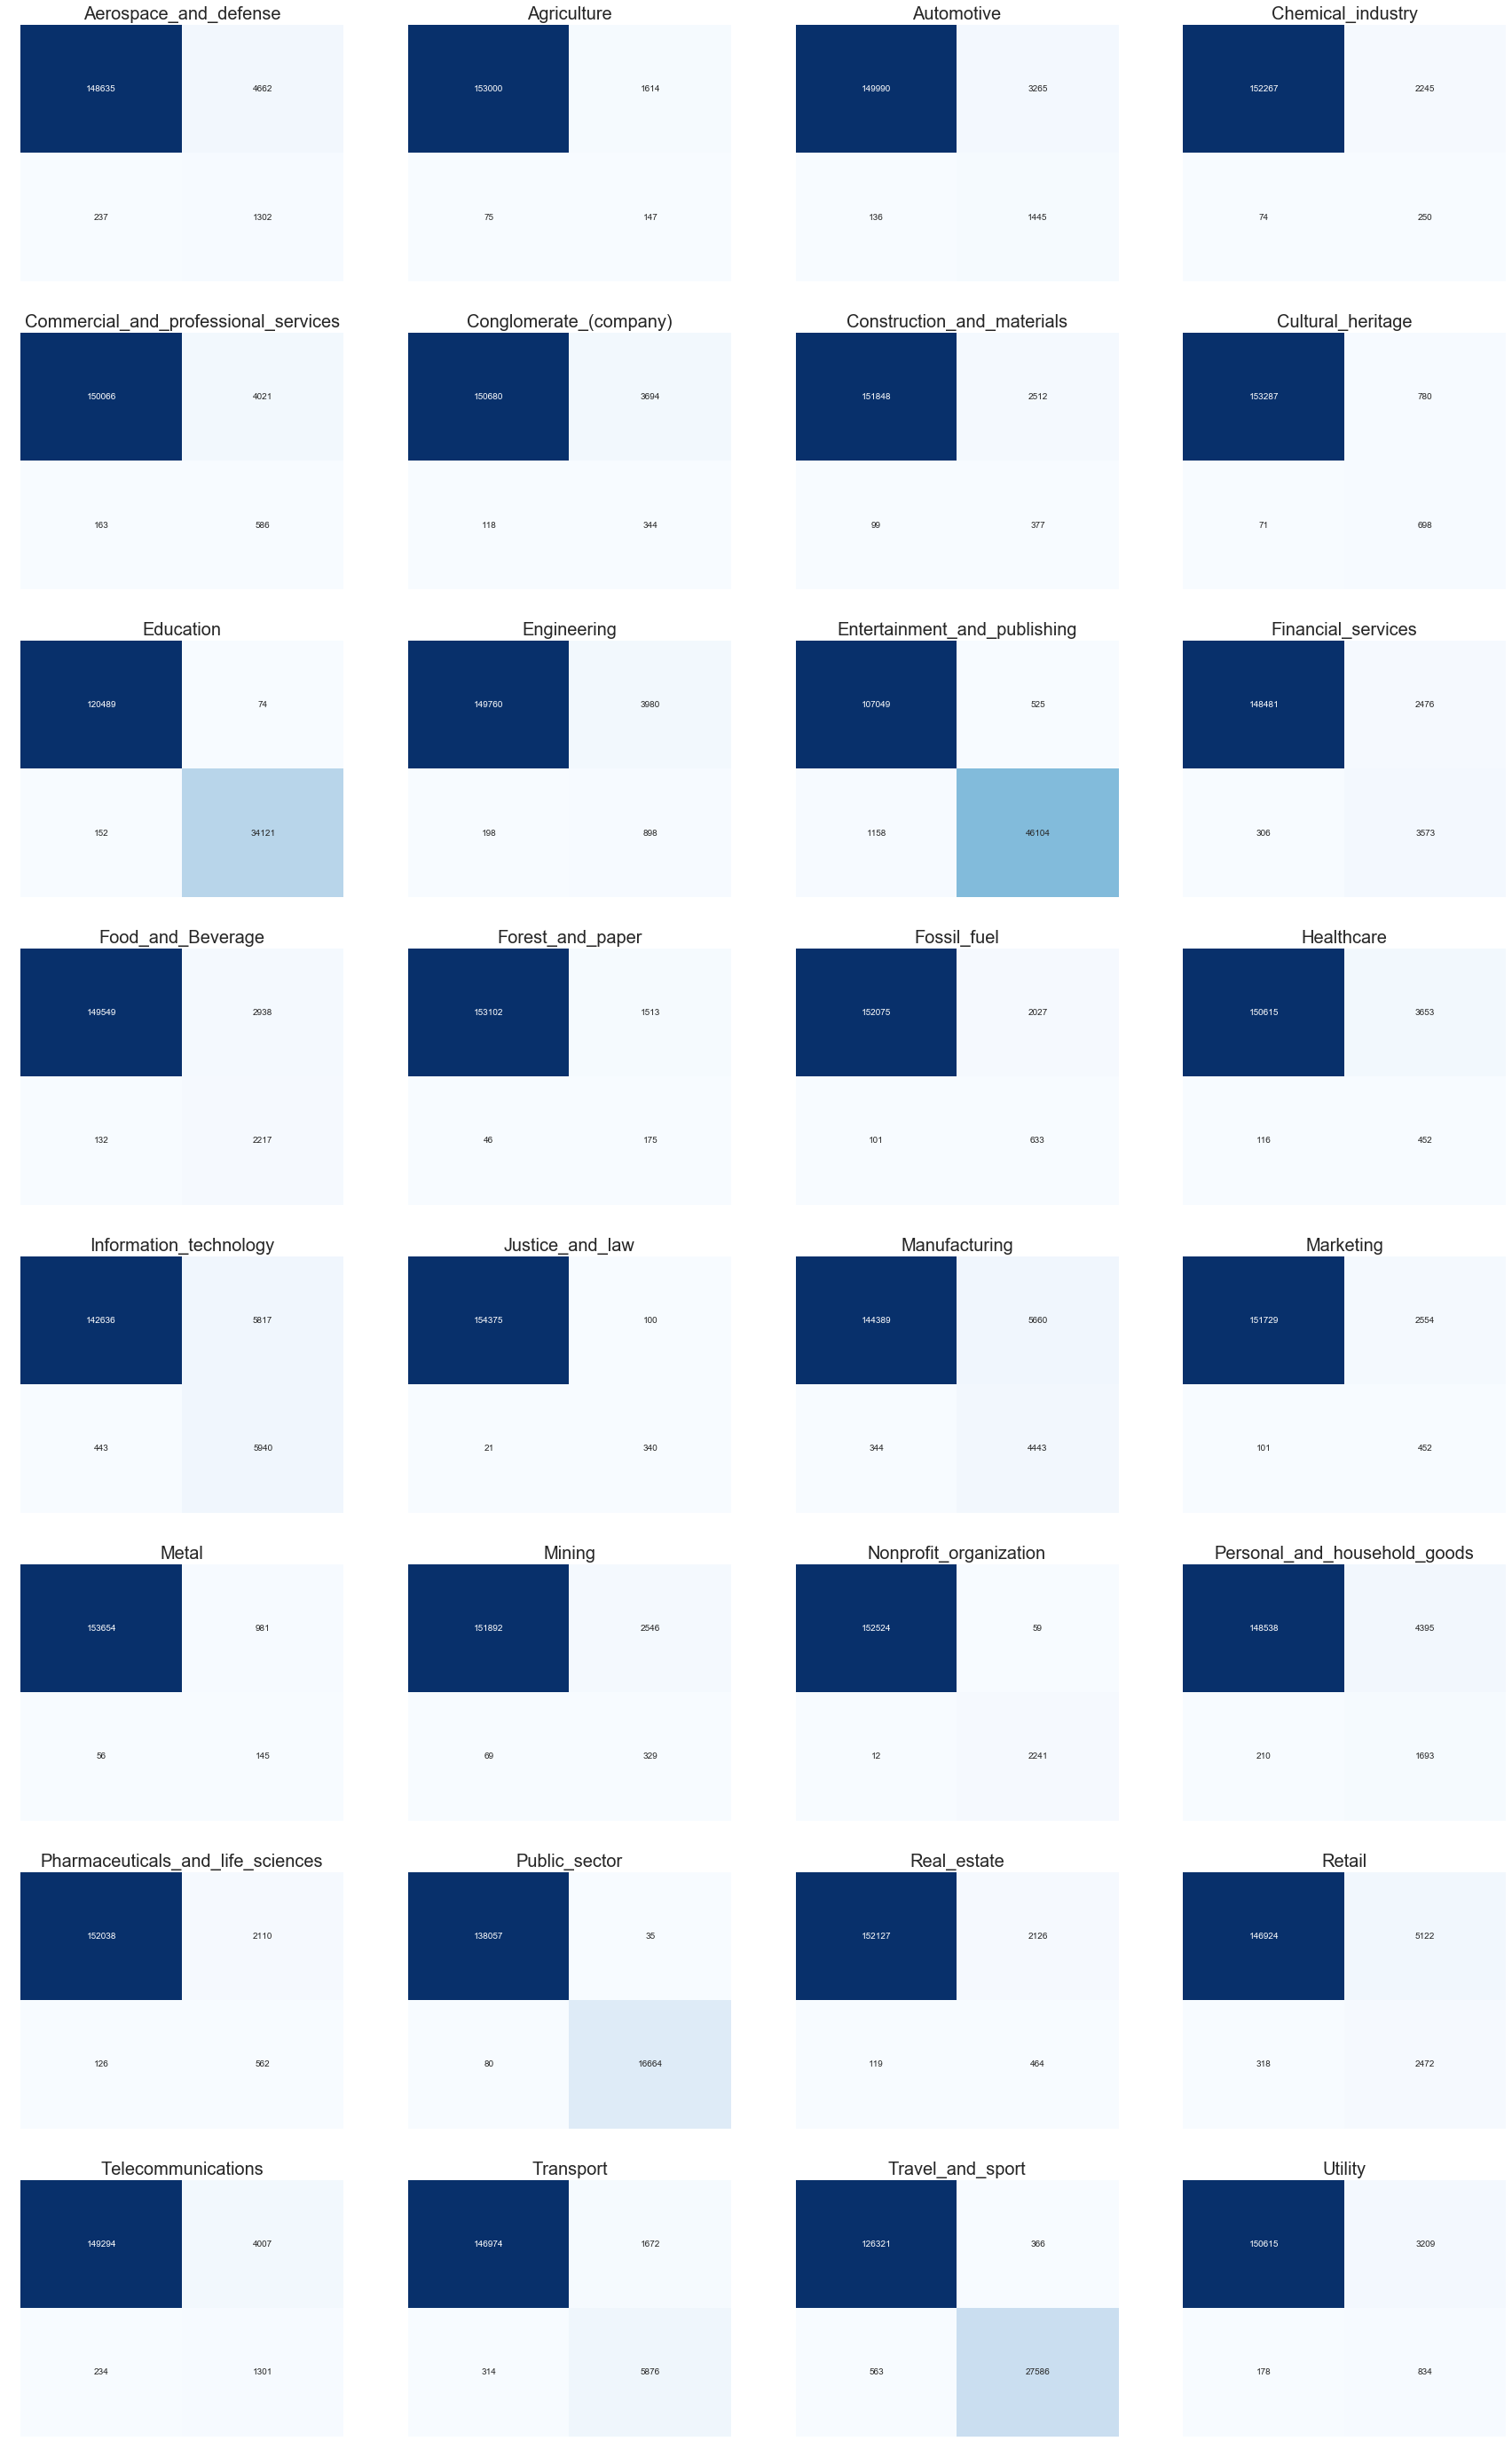

In [310]:
cm = plt.colormaps()
fig = plt.figure(figsize= (30, 50))
for i in range(len(ind_labels)):
    cm = confusion_matrix(y_test.iloc[:,i],lr_pred.iloc[:,i])
    ax = fig.add_subplot(8 ,4,i+1)
    sns.heatmap(cm, robust= True, annot= True, fmt= 'g', cmap='Blues', cbar=False, ax= ax)
    ax.set_title(ind_labels[i], size= 20)
    ax.axis('off')

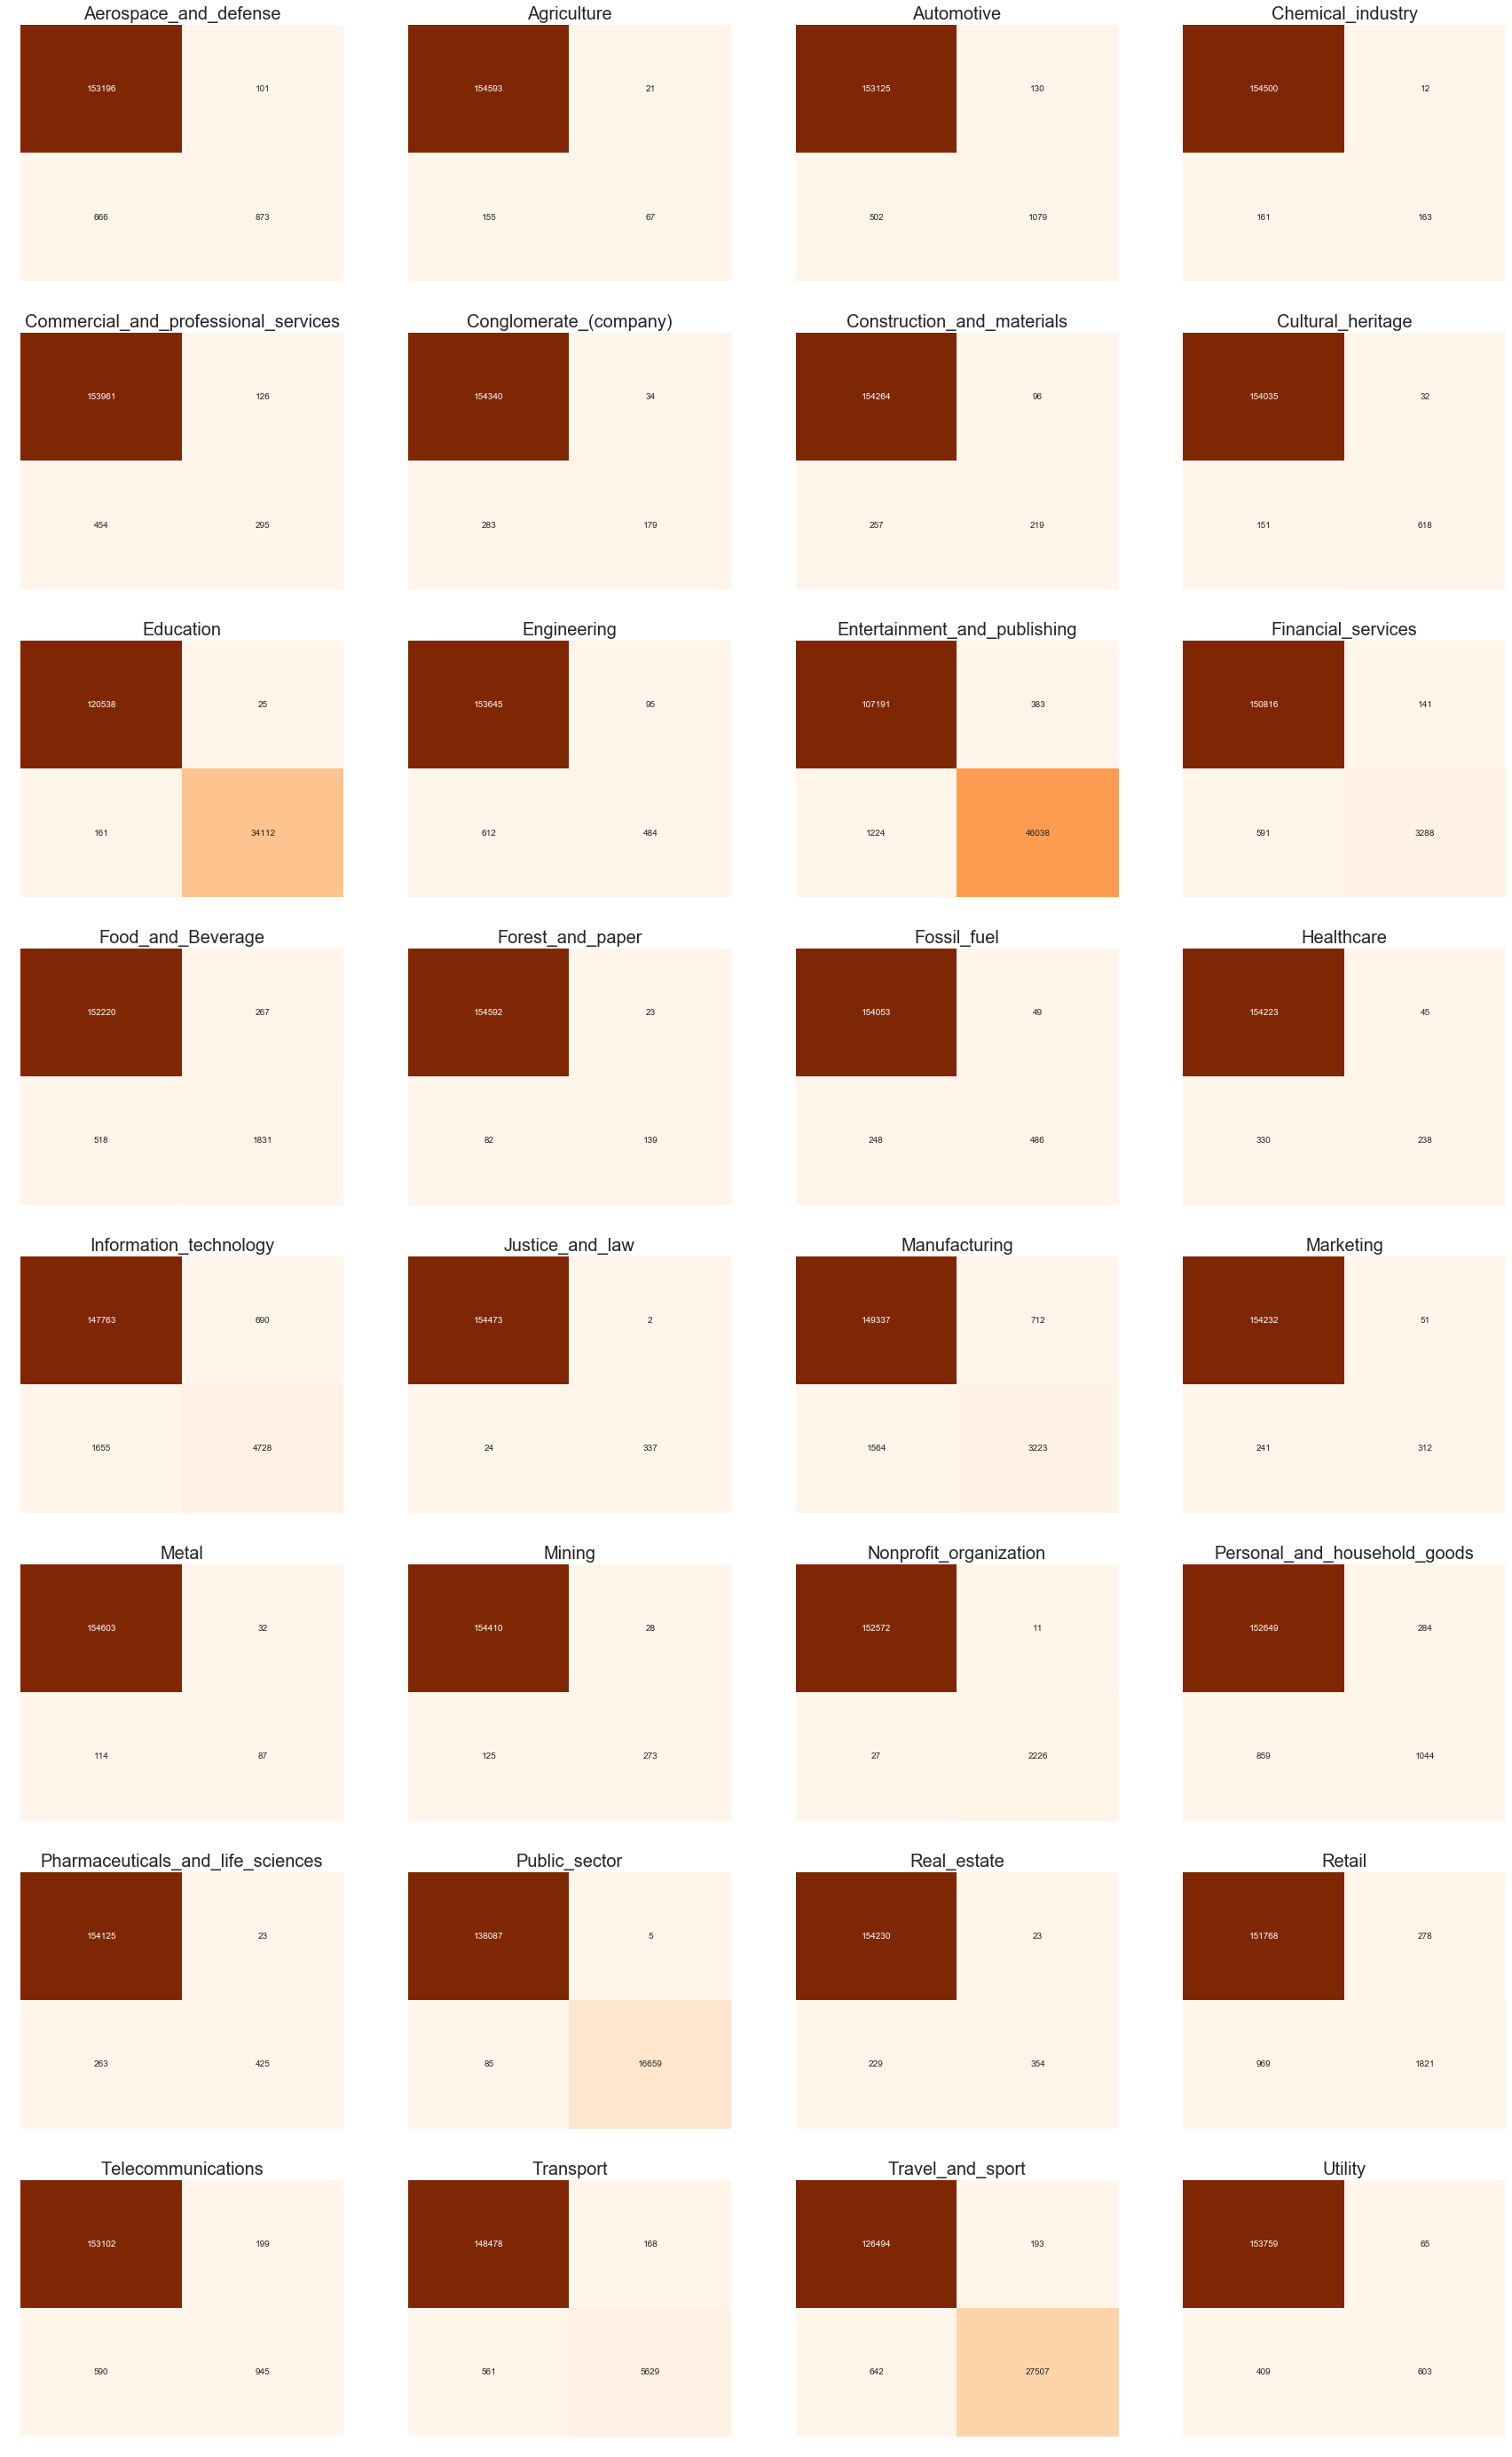

In [316]:
svc_pred= pd.DataFrame(svc_pred)
cm = plt.colormaps()
fig = plt.figure(figsize= (30, 50))
for i in range(len(ind_labels)):
    cm = confusion_matrix(y_test.iloc[:,i],svc_pred.iloc[:,i])
    ax = fig.add_subplot(8 ,4,i+1)
    sns.heatmap(cm, robust= True, annot= True, fmt= 'g', cmap='Oranges', cbar=False, ax= ax)
    ax.set_title(ind_labels[i], size= 20)
    ax.axis('off')